## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [6]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [7]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    x = np.ones(N) * x_0 + (v * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

# Generating biased trajectory
# and measurements

## Parameters

In [18]:
N = 200
sigma_a = 0.2
q = 0.2
sigma_n = 20
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

## Generating

In [19]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)

# Kalman filter in assumption of unbiased noise

In [20]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman(X_0, P_0, z, T, H, R, Q, Kext = None):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    XF= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        if Kext is None:
            tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
            tmp2 = H.transpose().dot(tmp1)
            K[i] = P[i].dot(tmp2)
        else:
            K[i] = Kext[i]
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
        if i + 6 < len(z):
            XF[6 + i] = T6.dot(X[i])
    return X,K,P,XF
        

In [21]:
X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)

# Plot the results for unbiased Kalman

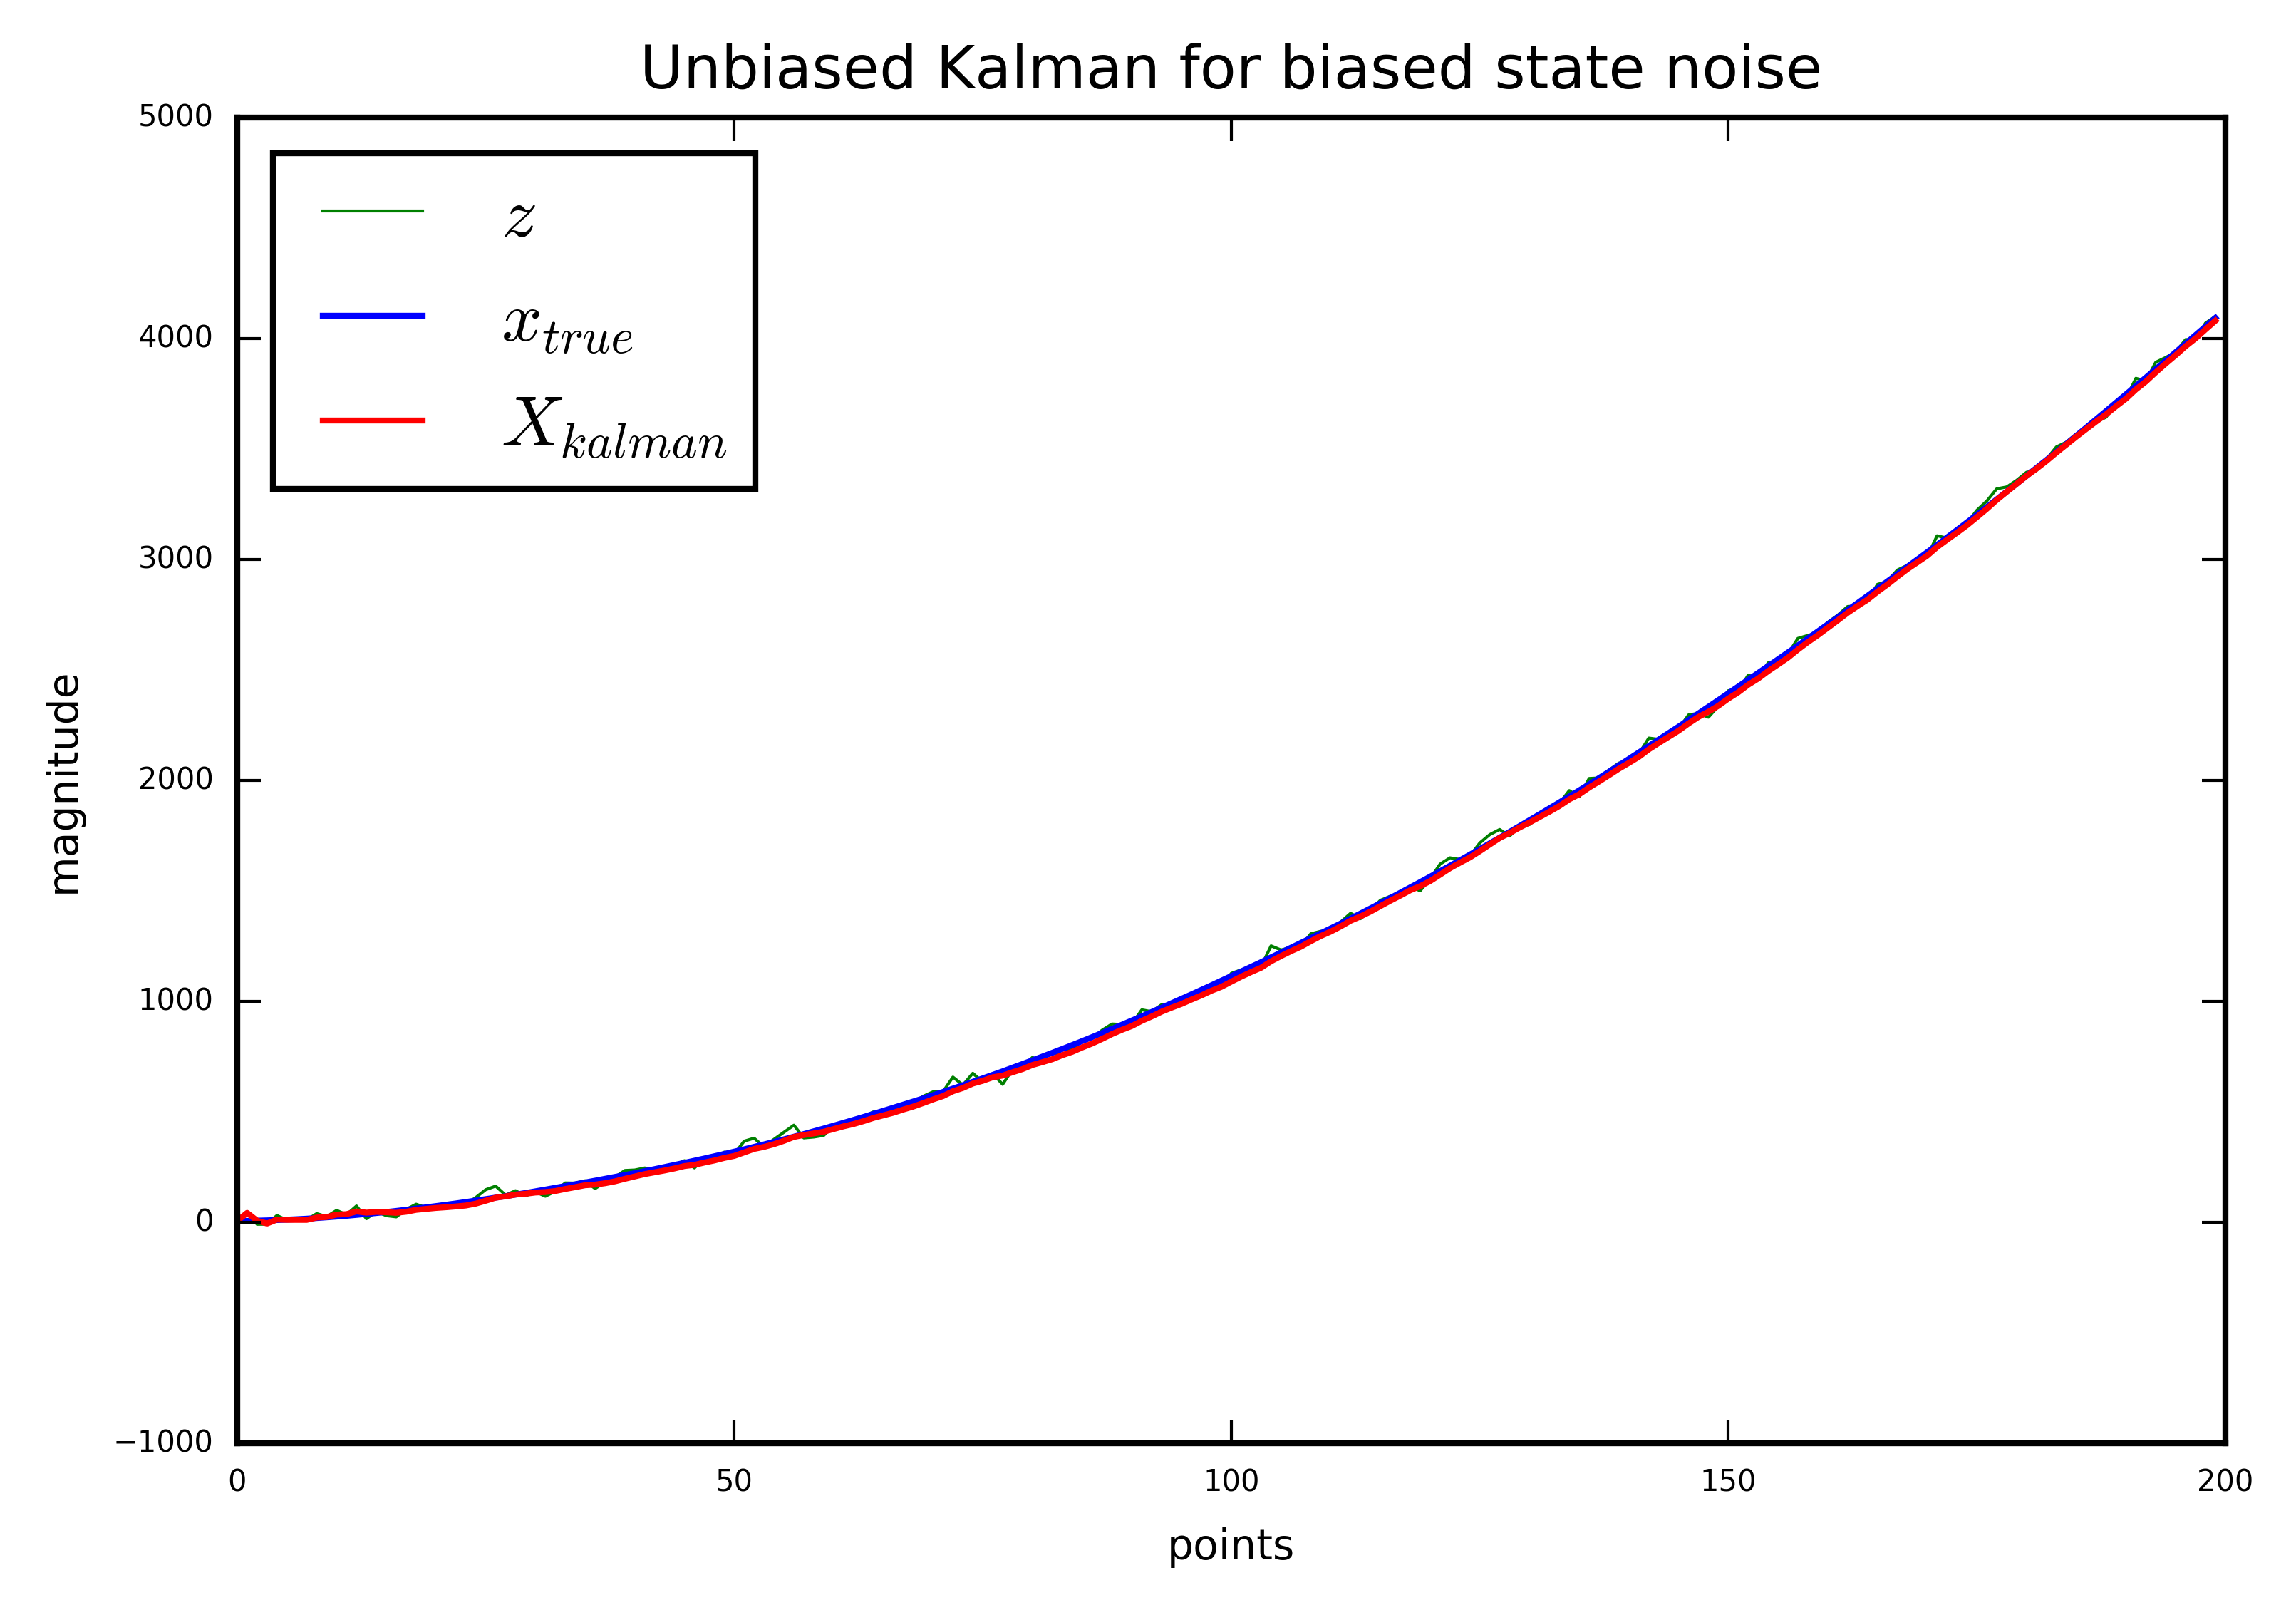

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Unbiased Kalman for biased state noise', fontsize = 10)
ax.plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.legend(loc='upper left')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

In [35]:
P_0 = np.matrix([[10000, 0], [0,10000]])
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)
    X, K, P, XF = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


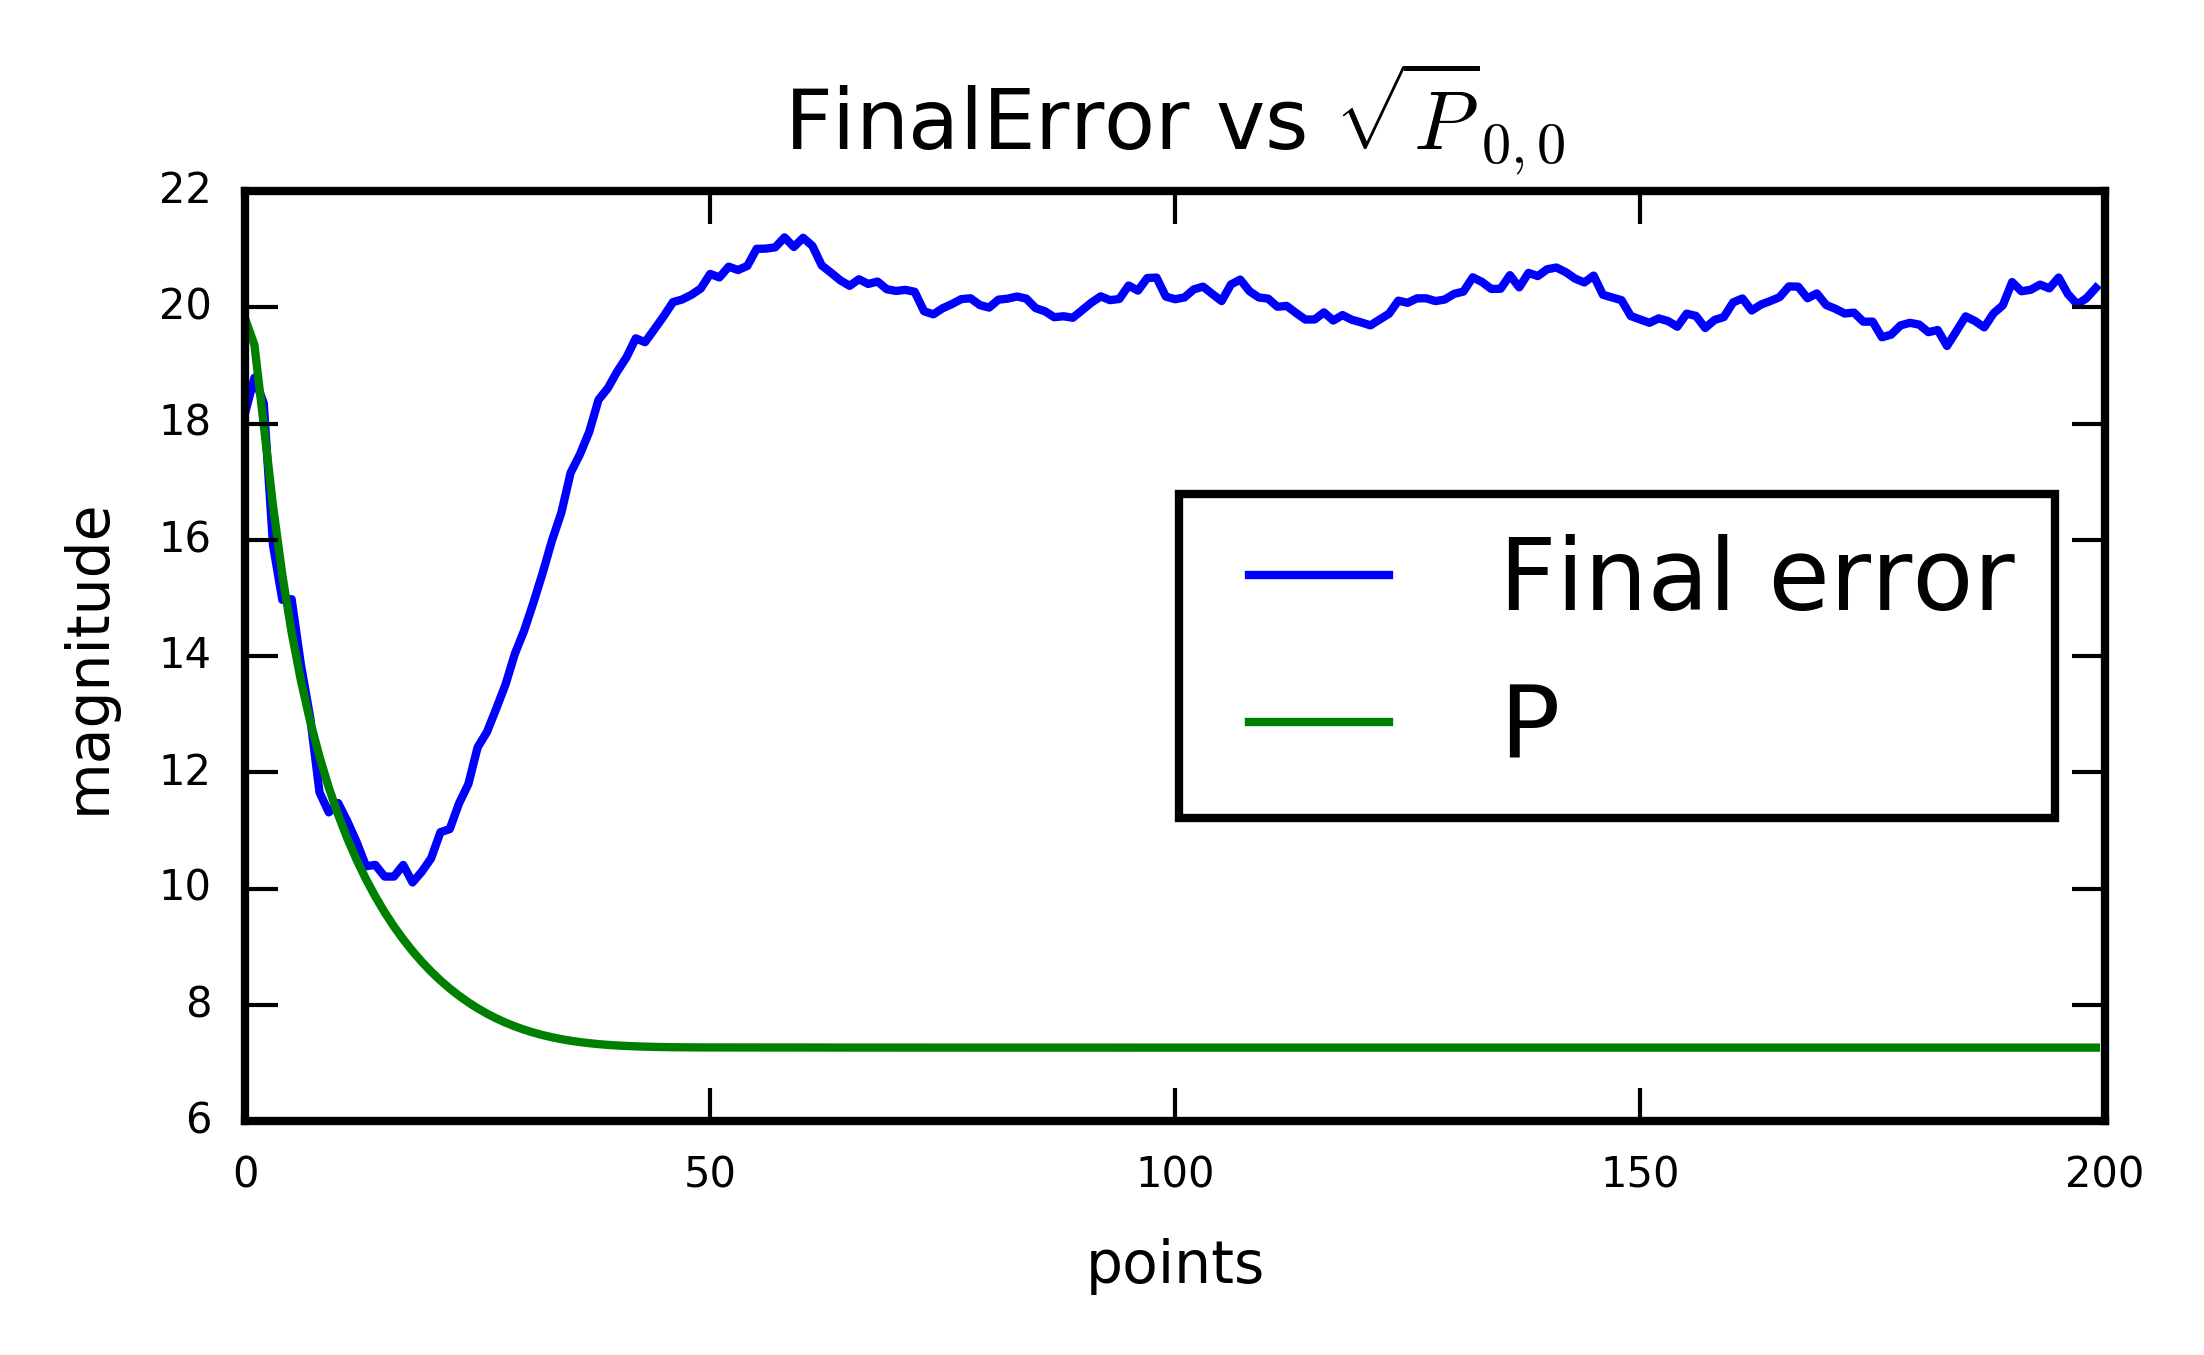

In [36]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title('FinalError vs $\sqrt{P}_{0,0}$', fontsize = 10)
ax.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'Final error')
ax.plot(range(N),P[:,0,0]**0.5,'g',  label = 'P')
ax.legend(loc='center right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

## Filter is non-optimal and true estimation error doesn't correspond to $\sqrt{P}_{0,0}$ anymore

# Now we correct Kalman filter taking into account biased noise

In [28]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman_biased(X_0, P_0, z, T, H, R, Q, Gq = 0, Kext = None):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    XF= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0) + Gq
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        if Kext is None:
            tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
            tmp2 = H.transpose().dot(tmp1)
            K[i] = P[i].dot(tmp2)
        else:
            K[i] = Kext[i]
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
        if i + 6 < len(z):
            XF[6 + i] = T6.dot(X[i])
    return X,K,P,XF
        

In [29]:
Gq = G*q

# Now we compare true estimation errors and $\sqrt{P}_{0,0}$ for optimal (corrected) Kalman filter

In [32]:
P_0 = np.matrix([[10000, 0], [0,10000]])
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorXFore = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t, q)
    X, K, P, XF = kalman_biased(X_0, P_0, z, T, H, R, Q, Gq)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorXFore[:,i] = (x-XF[:,0,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


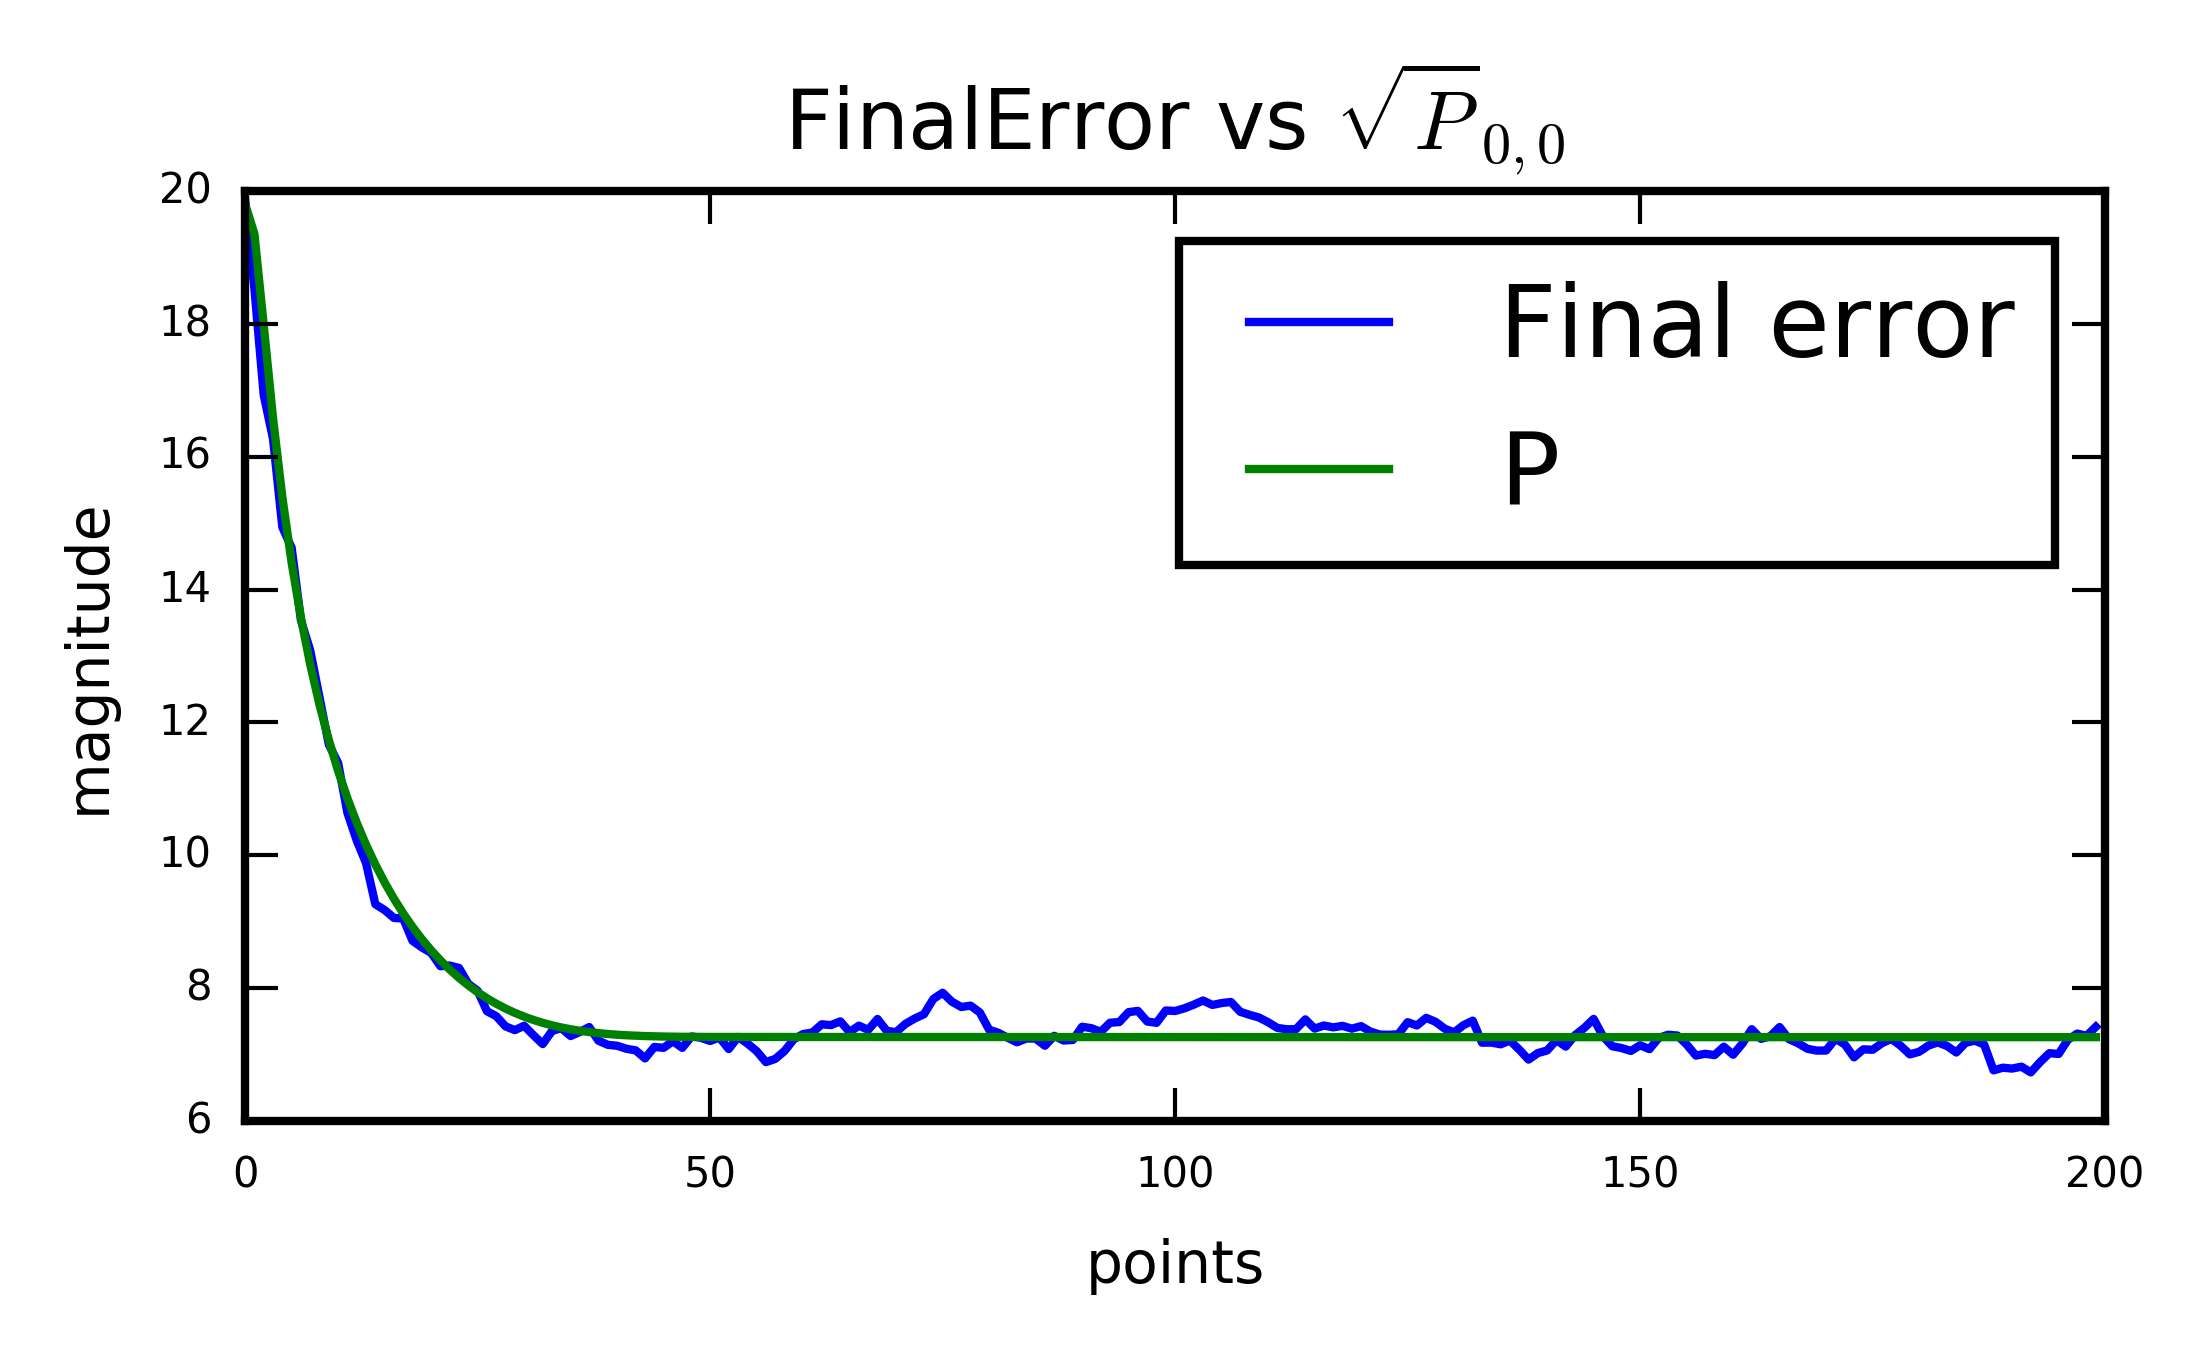

In [33]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi = 600)
ax.set_title('FinalError vs $\sqrt{P}_{0,0}$', fontsize = 10)
ax.plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'Final error')
ax.plot(range(N),P[:,0,0]**0.5,'g',  label = 'P')
ax.legend(loc='upper right')
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

# Today we learned how to improve Kalman filter to take into account biased noise and how unbiased Kalman filter behaves for biased state noise